In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
## Download and print the top five entries
df = pd.read_csv('data_full.csv',parse_dates=['dt'])
df_kmean = pd.read_csv('data_kmean.csv')
df_extra = pd.read_csv('data_extra_f.csv',parse_dates=['dt'])

In [3]:
df_extra.head()

,dt,Latitude,Longitude,Month,Year,Distance to ocean,CO2,cumul(CO2),Altitude,City,Country,Continent,$\Delta$T
0,1801-01-01,50.63,6.34,1.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,1.581
1,1801-02-01,50.63,6.34,2.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,1.909
2,1801-03-01,50.63,6.34,3.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,4.690
3,1801-04-01,50.63,6.34,4.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,-3.166
4,1801-05-01,50.63,6.34,5.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,-1.270


In [4]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438339 entries, 0 to 2438338
Data columns (total 13 columns):
dt                   datetime64[ns]
Latitude             float64
Longitude            float64
Month                float64
Year                 float64
Distance to ocean    float64
CO2                  float64
cumul(CO2)           float64
Altitude             float64
City                 object
Country              object
Continent            object
$\Delta$T            float64
dtypes: datetime64[ns](1), float64(9), object(3)
memory usage: 241.8+ MB


########################################################################

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7981058 entries, 0 to 7981057
Data columns (total 9 columns):
dt           datetime64[ns]
Latitude     float64
Longitude    float64
Month        float64
Year         float64
City         object
Country      object
Continent    object
$\Delta$T    float64
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 548.0+ MB


We recall that we have three DataFrames : 
- `df` is the original data set where we just transformed the temperature into annual temperature variation, denoted by $\Delta$T.
- `df_extra` is obtained from `df` by adding extra features, namely the altitude, the distance to the nearest ocean and the CO2 emission. 
- `df_kmean` is also constructed from `df` and will be used for the $k$-mean algorithm in the ML part.

We need to underline an important aspect : The first data set contains almost $8$ millions observations while the second one only contains $2500000$ samples, which is less than one third of the original set! This is the main disadvantage of having added extra variables. We can visualize this loss of information by plotting the coordinates of all cities appearing in the two data sets. For this, it is more convenient to group the DataFrames per city and compute the mean, since the coordinates are constant for a given city.

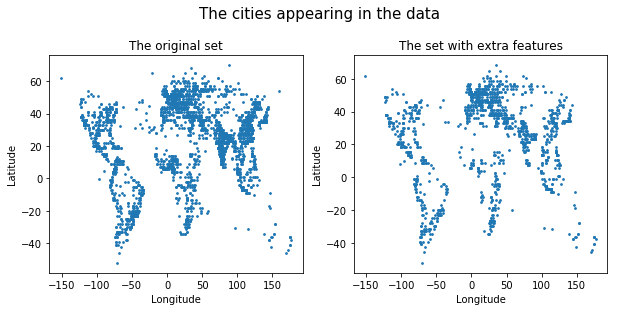

In [6]:
## Scatter plot of the coordinates
##################################
## Group the two frames by city
df_city = df.groupby('City').mean()
df_extra_city = df_extra.groupby('City').mean()

fig, axes = plt.subplots(1,2,figsize=(10,4))
## The original frame
axes[0].scatter(df_city.Longitude.values,df_city.Latitude.values,s=3)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('The original set')
## The second frame
axes[1].scatter(df_extra_city.Longitude.values,
                                        df_extra_city.Latitude.values,s=3)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('The set with extra features')
plt.suptitle('The cities appearing in the data',
             fontsize=15).set_position([0.5,1.05])
plt.show()

We indeed lost a lot of cities! A legitimate question that can be asked is whether or not we get compensation for this. In other words, do these extra variables have an influence on the variation of the annual temperature ? This question can be partially answered through scatter plots of $\Delta$T against our features. Before doing this, let's just check that `df_extra` does not contain any incorrect informations, for example a too negative altitude.

In [7]:
df_extra.describe()

,Latitude,Longitude,Month,Year,Distance to ocean,CO2,cumul(CO2),Altitude,$\Delta$T
count,2.438339e+06,2.438339e+06,2.438339e+06,2.438339e+06,2.438339e+06,2.438339e+06,2.438339e+06,2.438339e+06,2.438339e+06
mean,2.733283e+01,1.846455e+01,6.490004e+00,1.939568e+03,2.324311e+05,1.237937e+02,3.651262e+03,1.703547e+02,8.300877e-03
std,2.576337e+01,7.165758e+01,3.449947e+00,5.108608e+01,2.924360e+05,3.522859e+02,1.370568e+04,1.308108e+03,1.878243e+00
min,-5.224000e+01,-1.511300e+02,1.000000e+00,1.801000e+03,2.467045e+02,-5.961328e+00,-3.088752e+00,-9.999000e+03,-2.133100e+01
25%,1.366000e+01,-6.550000e+00,3.000000e+00,1.906000e+03,4.089020e+04,1.538880e-01,1.516896e+00,2.100000e+01,-8.830000e-01
50%,3.617000e+01,1.491000e+01,6.000000e+00,1.948000e+03,1.059320e+05,5.576600e+00,9.908922e+01,9.700000e+01,2.000000e-03
75%,4.742000e+01,7.372000e+01,9.000000e+00,1.981000e+03,3.347208e+05,6.409620e+01,1.336986e+03,2.970000e+02,8.890000e-01
max,6.831000e+01,1.769500e+02,1.200000e+01,2.013000e+03,2.331102e+06,2.607641e+03,1.419959e+05,3.972000e+03,2.398500e+01


Observe that the minimal value for the $\mathrm{CO}_2$ emission is negative, which is impossible. Also the minimal value of the altitude is too negative; namely the lowest city in the world is Jéricho in Cisjordania (−258 m). We can count the number of wrong observations as follows :

In [8]:
incorrect = ((df_extra['Altitude']<-258) | (df_extra['CO2']<0)).sum()
print('Number of incorrect observations : ',incorrect)

Number of incorrect observations :  42760


This is not too much so we can just drop them.

In [9]:
## Filter incorrect values
idx = ((df_extra['Altitude']>= -258) & (df_extra['CO2']>=0))
df_extra = df_extra[idx]

Now we can scatter plot the variables against $\Delta$T.

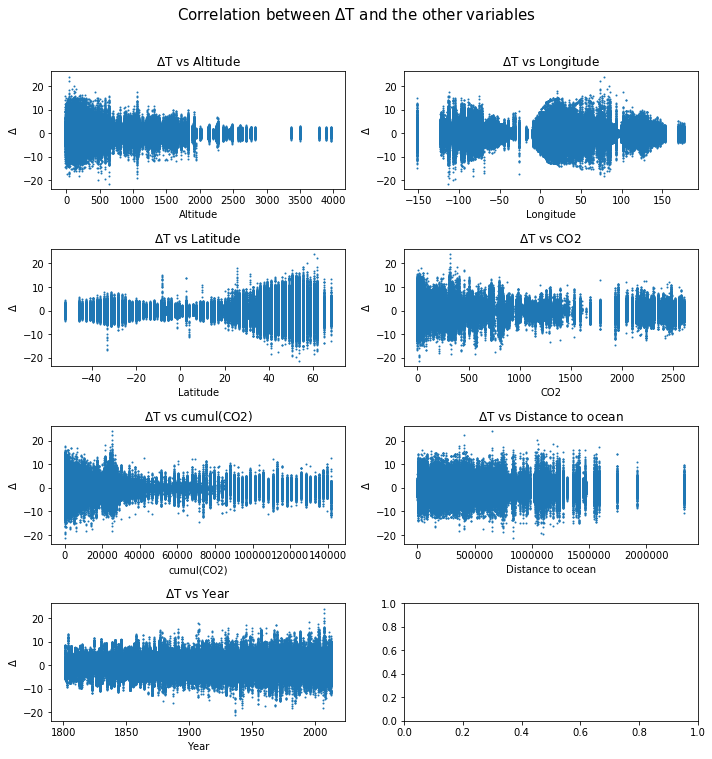

In [10]:
cols = ['Altitude','Longitude','Latitude','CO2','cumul(CO2)',
        'Distance to ocean','Year']
fig,axes = plt.subplots(4,2,figsize=(10,10))
for col,ax in zip(cols,axes.ravel()):
    ax.scatter(df_extra[col].values,df_extra['$\Delta$T'],s=1)
    ax.set_xlabel(col)
    ax.set_ylabel('$\Delta$')
    ax.set_title('$\Delta$T vs '+col)
plt.suptitle('Correlation between $\Delta$T and the other variables',
            fontsize=15).set_position([0.5,1.05])
plt.tight_layout()
plt.show()

From the above scatter plots, we can already draw some conclusions. Certainely, the geographic coordinates are the variables that most influence the temperature variation and amoung them the Latitude is in the pole position : $\Delta$T is more important when we get closer to the poles. Similarly, the altitude seems to be a relevant explicative factor since $\Delta$T is small for cities lying in high altitude. Concerning the other features, the distance to the nearest ocean does not seem to affect the annual temperature variation while we are able to distinguish a tiny pattern for the $\mathrm{CO}_2$ and its cumulative version : it seems that there is a negative correlation. 

In conclusion, we may think that the extra features compensates for the loss of observations and it will be interesting to do the following in the ML part : We evaluate the MAE score on `df_extra` with and without the extra features. If they are equivalent, there is no gain to include these extra features so we will get back to the complete data set.

Let's now have a look at the distributions of the values of each feature that will be used for our machine learning models. This is crucial step because it allows use to detect and correct some disymmetries that may affect models performance. 

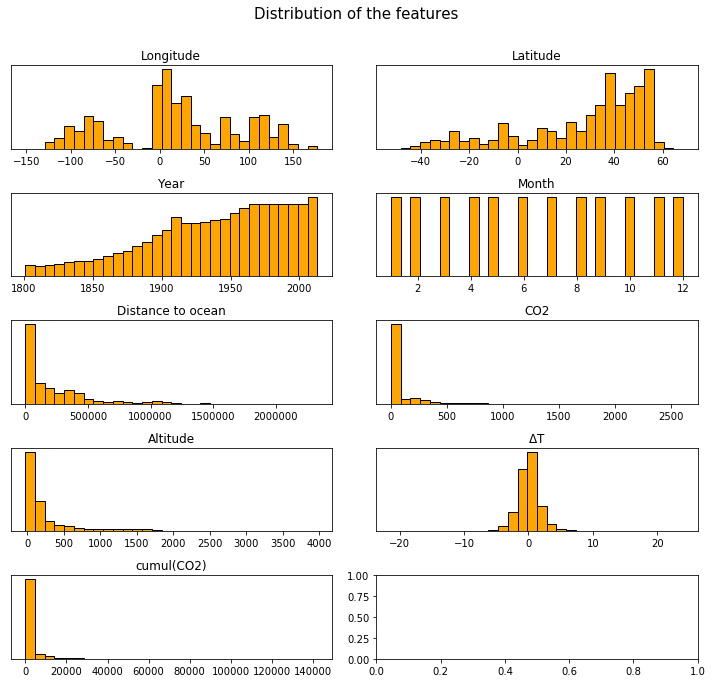

In [11]:
## Plot the distribution of each features
#########################################
## Columns used for the models
features = ['Longitude','Latitude','Year','Month','Distance to ocean',
           'CO2','Altitude','$\Delta$T','cumul(CO2)']
## The plots
fig,axes = plt.subplots(5,2,figsize=(10,9))
for col,ax in zip(features,axes.ravel()):
    ax.hist(df_extra[col].values,bins=30,edgecolor='black',color='orange')
    ax.set_title(col)
    ax.get_yaxis().set_visible(False)

plt.suptitle('Distribution of the features',
                 fontsize=15).set_position([0.5,1.05])
plt.tight_layout()
plt.show()

We observe that 'Month' and 'Longitude' rather have symmetric distribution. We also have less temperature observations before the beginning of the 20th century, which is certainly due to the lack of technical means. 

The 'Latitude' is a bit skewed on the right, something that we could have deduced from the first scatter plot; namely we have more points in the North hemisphere. The same is also true for the 'Annual Temperature Difference' : It may be a first insight of the global warming. To these two features, we can apply a logarithm transformation and plot again their new distrinutions.

Finally, we note that the columns involving ocean, $\mathrm{CO}_2$ and altitude contain a lot of small values. The usual way to deal with this is to create for example an extra column that indicates (with zero or one) that the value is small. We could also apply a logarithm transformation to these three features.

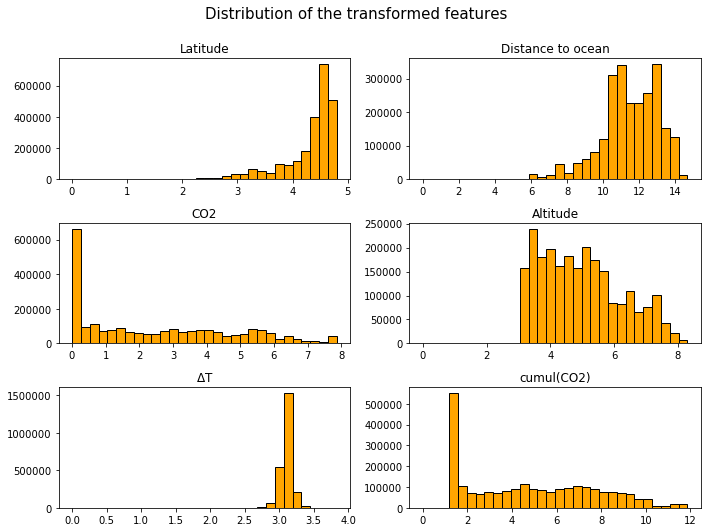

In [12]:
## The distribution after applying logarithm transformation
###########################################################
def Log_transform_test(df):
    ## Work on a copy
    df = df.copy()
    ## The columns to apply the logarithm transform
    cols_log = ['Latitude', 'Distance to ocean','CO2','Altitude',
                '$\Delta$T','cumul(CO2)']
    ## Apply the transformation and plot them
    fig, axes = plt.subplots(3,2,figsize=(10,7))
    for col,ax in zip(cols_log,axes.ravel()):
        ## Minimal value
        m = df[col].min()
        transf_feat = (df[col]-m).apply(np.log1p)
        ax.hist(transf_feat.values,bins=30,edgecolor='black',
                color='orange')
        ax.set_title(col)
    plt.suptitle('Distribution of the transformed features',
                     fontsize=15).set_position([0.5,1.05])
    plt.tight_layout()
    plt.show()  

Log_transform_test(df_extra)

We decide to create extra columns for the logarithm transformation of the Distance to ocean, $\mathrm{CO}_2$ emission and the altitude. We think that the annual temperature difference is quite well symmetric and the transformation does not improve the shape too much. We may also create a binary column that indicates if the log(cumul(CO2)) is less than $1$.

In [13]:
## Add extra columns for logarithm transformation
cols_to_transform = ['Altitude','cumul(CO2)','Distance to ocean']
for col in cols_to_transform:
    m = df_extra[col].min()
    df_extra['log('+col+')'] = (df_extra[col]-m).apply(np.log1p)

## Add binary column telling if cumul(CO2) is less than 2
def binary(x):
    if x<=2:
        return 1
    else:
        return 0

df_extra['CO2 small'] = df_extra['log(cumul(CO2))'].apply(binary)

In [14]:
df_extra.head()

,dt,Latitude,Longitude,Month,Year,Distance to ocean,CO2,cumul(CO2),Altitude,City,Country,Continent,$\Delta$T,log(Altitude),log(cumul(CO2)),log(Distance to ocean),CO2 small
0,1801-01-01,50.63,6.34,1.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,1.581,5.313206,1.40824,11.997598,1
1,1801-02-01,50.63,6.34,2.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,1.909,5.313206,1.40824,11.997598,1
2,1801-03-01,50.63,6.34,3.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,4.690,5.313206,1.40824,11.997598,1
3,1801-04-01,50.63,6.34,4.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,-3.166,5.313206,1.40824,11.997598,1
4,1801-05-01,50.63,6.34,5.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,-1.270,5.313206,1.40824,11.997598,1


Since the distribution of the temperature column looks rather symmetric, we can use the usual $z$-score criterion to detect outliers. We recall that in practice, the number of outliers should be around $5$% of the total number of observations, which corresponds to the points greater than $2$ (in absolute value) in a normal distribution. Hence we can compute the number of points satisfying $|z$-score|$ >2$ :

In [15]:
## Compute the number of outliers with threshold=2
s = df['$\Delta$T']
s_extra = df_extra['$\Delta$T']
z_score = (s-s.mean())/(s.std())
z_score_extra = (s_extra-s_extra.mean())/(s_extra.std())
idx = np.abs(z_score)>2
idx_extra = np.abs(z_score_extra)>2
perc = (idx.sum()/len(df))*100
perc_extra = (idx_extra.sum()/len(df_extra))*100
print('Percentage of outliers in df : {:.3f} %'.format(perc))
print('Percentage of outliers in df_extra : {:.3f} %'.format(perc_extra))

Percentage of outliers in df : 5.646 %
Percentage of outliers in df_extra : 5.595 %


This is quite satisfactory so we decide to filter the outliers with respect to this threshold.

In [16]:
## Filter the outliers
df = df[~idx]
df_extra = df_extra[~idx_extra]

We want to investigate possible relations between the variables involving temperature, time and latitude. A preliminary visualization could consist in a scatter plot of the mean annual temperature variation against the latitude. In order to have a better overview and avoid too many oscillations, we may average over $25$ years. For instance we consider the averaging over $1900-1925$, $1925-1950$,... To do this, we filter with respect to these year intervals, group the DataFrame per latitude and then compute the mean.

From now on and in view of the first scatter plot showing the repartition of the cities in the two data sets, we will produce visual plots from the complete set `df`.

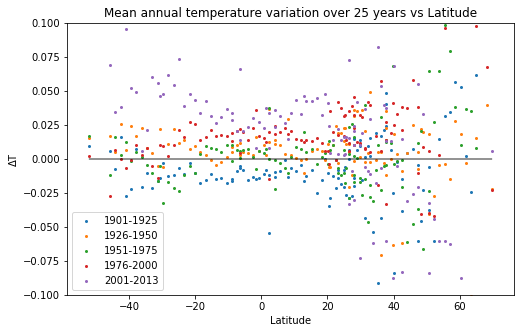

In [17]:
## years
years = np.arange(1900,2001,25) # 1970-1980, 1980-1990, 1990-2000, 2000-2010
## The scatter plot
fig, axes = plt.subplots(1,1,figsize=(8,5))
for year in years:
    ## Filter with respect to this decade
    filter_df = df[(df['Year']>year) & (df['Year']<=year+25)]
    ## Groupby by Latitude and compute the annual mean
    filter_df = filter_df.groupby('Latitude').mean()
    ## Plot
    x = filter_df.index.values
    y = [0]*len(x)
    if year == 2000:
        plt.scatter(x,filter_df['$\Delta$T'].values,s=4,
                label=str(year+1)+'-'+str(year+13))
    else:
        plt.scatter(x,filter_df['$\Delta$T'].values,s=4,
                label=str(year+1)+'-'+str(year+25))
        
    plt.plot(x,y,linewidth=0.2,color='black')
    plt.legend()
plt.xlabel('Latitude')
plt.ylabel('$\Delta$T')
plt.ylim(-0.10,0.10)
plt.title('Mean annual temperature variation over 25 years vs Latitude')
plt.show()

Maybe it is important to explicit the meaning of the above figure. Given a point $(x,y)$ and an interval of years, say $1976-2000$, then between these two dates, the mean annual temperature variation at the latitude $x$ is equal to $y$.

From this plot, we can observe one obvious pattern : The mean annual temperature variation tends to grow with the time when the Latitude variable belongs to the interval $[-30,30]$. 

It is a bit more difficult to establish the same kind of conclusion when we approach the poles because the clusters are not so easy to distinguish. 
At least we have a confirmation of what we saw in the scatter plot representing the Latitude vs the temperature variation; the amplitude becomes very large when we approch the poles.

In order to have a global visualization and a better idea in what is going on higher latitudes, we can plot these intervals of years using scatter plots with colors indicating the intensity of the temperature variation. 

In [18]:
## The general function 
#######################
def plot_temp(df,months,title):
    years = np.arange(1900,2001,25) # 1
    fig,axes = plt.subplots(3,2,figsize=(9,8))
    ## The colorbar 
    cm = plt.cm.get_cmap('coolwarm')
    ## Plot all years
    ###################
    for year,ax in zip(np.flip(years),axes.ravel()):
        ## Filter with respect to the desired years
        filter_df = df[(df['Year']>year) & (df['Year']<=year+25)]
        ## Filter the seasons
        filter_df = filter_df[filter_df.Month.isin(months)]
        ## Groupby City and compute the annual mean
        filter_df = filter_df.groupby('City').mean()
        x = filter_df.Longitude.values
        y = filter_df.Latitude.values
        z = filter_df['$\Delta$T'].values
        ## Horizontal lines for -30 and 30 degree
        h = [30]*len(x)
        h_=[-30]*len(x)
        ## The scatter plot
        sc = ax.scatter(x, y,c=z, vmin=-0.2, vmax=0.2, s=3, cmap=cm)
        ## The two lines
        ax.plot(x,h,linewidth=0.35,color='black',linestyle='--')
        ax.plot(x,h_,linewidth=0.35,color='black',linestyle='--')
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([-30,30])
        if year == 2000:
            ax.set_title(str(year+1)+'-'+str(year+13))
        else:
            ax.set_title(str(year+1)+'-'+str(year+25))
    cbar = fig.colorbar(sc)

    cbar.set_label('$\Delta$T')
    plt.suptitle(title,fontsize=15).set_position([0.5,1.05])
    plt.tight_layout()
    plt.show()   

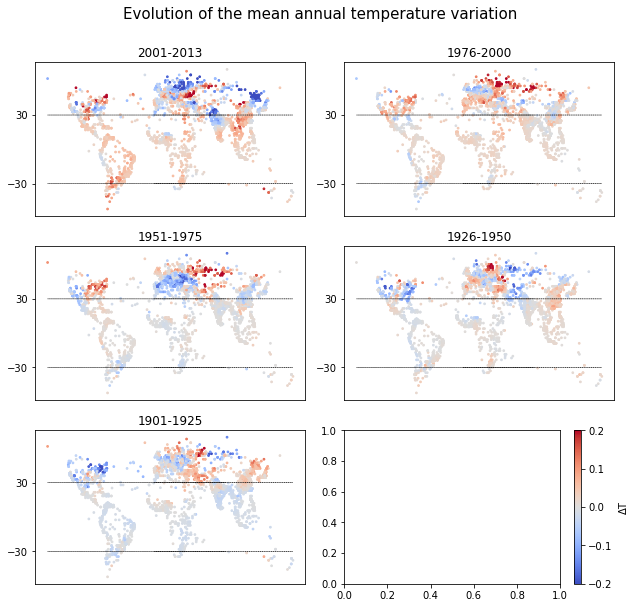

In [19]:
plot_temp(df,months=np.arange(1,13),
          title='Evolution of the mean annual temperature variation')

It is very interesting to note that $\Delta$T seems indeed to grow with the time when the latitude belongs to $[-30,30]$. 

In the other regions of the globe, i.e. principally above 30 degree, it is difficult to establish such linear relation. Nevertheless, we clearly observe clusters of points with strong $\Delta$T variation which can be either positive or negative. This means that the points $(x,y)$ on Earth with $y\geqslant 30$ are more sensitive to the annual variation of the temperature. We can investigate more deeply this difference by plotting the distribution of $\Delta$T in each continent between $2001$ and $2013$.

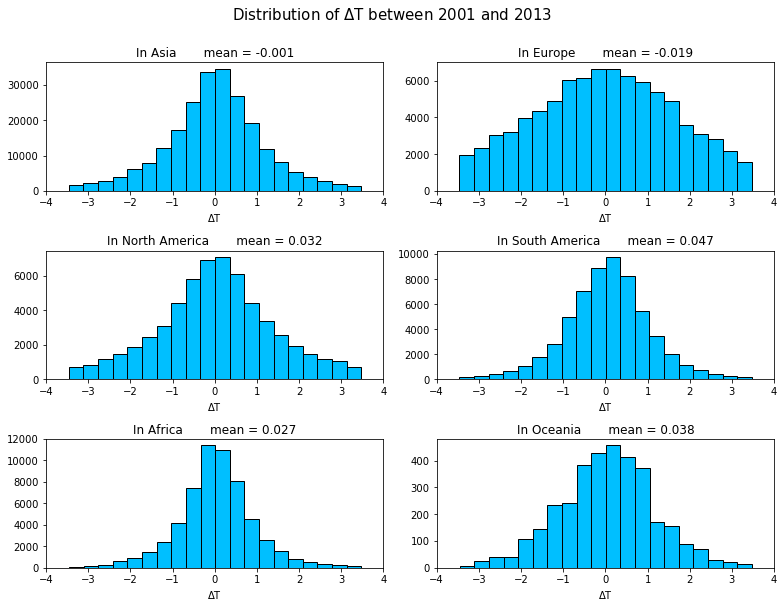

In [20]:
continents = list(df.Continent.value_counts().index)
fig,axes = plt.subplots(3,2,figsize=(11,8))
for cont,ax in zip(continents,axes.ravel()):
    ## Filter by continent and years
    df_filter = df[df.Continent==cont]
    df_filter = df_filter[(df_filter.Year>2000)&(df_filter.Year<=2013)]
    ax.hist(df_filter['$\Delta$T'].values,bins=20,edgecolor='black',
            color='deepskyblue')
    mean = df_filter['$\Delta$T'].values.mean()
    ax.set_title('In '+cont+'       mean = {:.3f}'.format(mean))
    ax.set_xlabel('$\Delta$T')
    ax.set_xlim(-4,4)
plt.suptitle('Distribution of $\Delta$T between 2001 and 2013',
            fontsize=15).set_position([0.5,1.05])
plt.tight_layout()
plt.show()

We recognize that the continents lying in the south hemisphere, especially Africa and South America, have a distribution which looks more flat at the tails. We could also say that $\Delta$T has a higher variance in the North hemisphere, which is particularly pronounced in Europe and can be quantitatively verified as follows :

In [21]:
## Compute the standard deviation of Delta T in each continent
##############################################################
std = df[(df.Year>2000)&(df.Year<=2013)].groupby('Continent').std()
std = std['$\Delta$T'].to_frame()
std.rename(
columns={'$\Delta$T':'Standard deviation of $\Delta$T between 2001 and 2013'},
    inplace=True)
std

,Standard deviation of $\Delta$T between 2001 and 2013
Continent,
Africa,0.909360
Asia,1.153909
Europe,1.633621
North America,1.360267
Oceania,1.128329
South America,1.005351


Finally, we can try to understand how $\Delta$T is distributed with respect to the seasons. Let's have a first insight using as before the `plot_temp()` function for winter and summer.

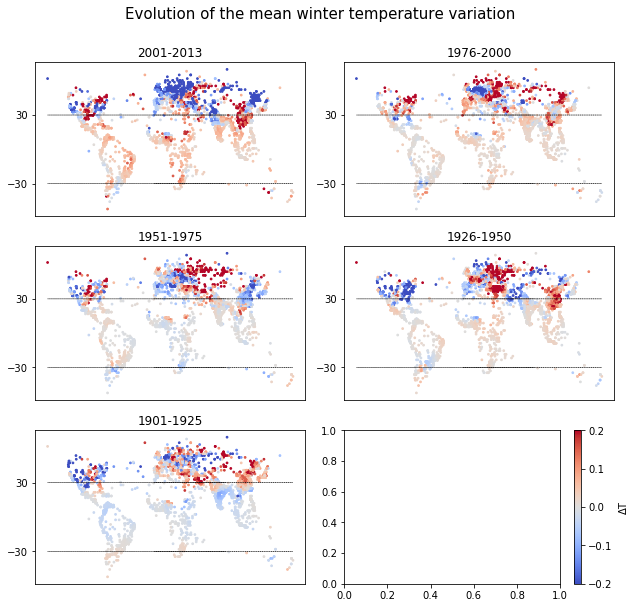

In [22]:
## Winter plot
plot_temp(df,months=[12,1,2,3],
          title='Evolution of the mean winter temperature variation')

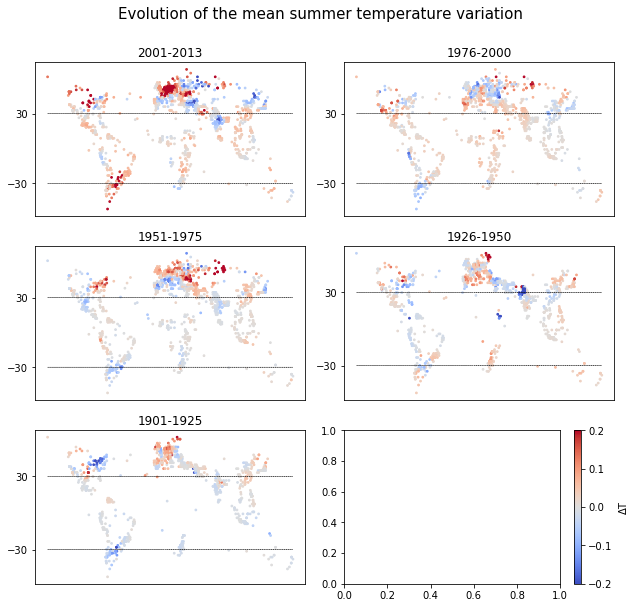

In [23]:
## Summer plot
plot_temp(df_extra,months=[6,7,8,9],
          title='Evolution of the mean summer temperature variation')

We observe that in the regions having latitudes $\geqslant 30$, the blue and red colors are more intense that in the previous map plot on the mean annual temperature difference and this is particularly pronounced during the winter season. Furthermore, we see that in Europe, the cold season tends to get colder and colder with the time. A strange phenomenon is that this trend seems to be reversed in North America, namely the cold season get hotter and hotter. 

We can conclude this EDA with a visual confirmation of the above observations.

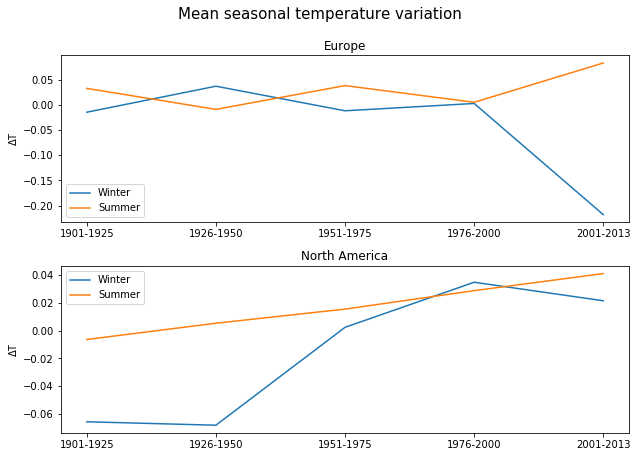

In [24]:
seasons = {'Winter':[12,1,2,3],'Summer':[6,7,8,9]}
continents = ['Europe','North America']

fig,axes = plt.subplots(2,1,figsize=(9,6))
for cont,ax in zip(continents,axes.ravel()):
    ## Filter the continent
    df_cont = df[df.Continent==cont]
    ## Plot the two curves
    for seas in seasons:
        mean_t = []
        ## Filter the months
        df_seas = df_cont[df_cont.Month.isin(seasons[seas])]
        for year in years:
            ## Filter the years
            df_year = df_seas[(df_seas.Year>year)&(df_seas.Year<=year+25)]
            
            ## Compute the mean
            mean = df_year['$\Delta$T'].mean()
            mean_t.append(mean)
        years_int = ['1901-1925','1926-1950','1951-1975','1976-2000',
                      '2001-2013']
        ax.plot(years_int,mean_t,label=seas)
        ax.set_ylabel('$\Delta$T')
        ax.set_title(cont)
    ax.legend()
plt.suptitle('Mean seasonal temperature variation',
             fontsize=15).set_position([0.5,1.05])
plt.tight_layout()
plt.show()

In [25]:
## Save csv files
#################
df_extra.to_csv('data_extra_ML.csv',index=False,encoding='utf-8')
df.to_csv('data_ML.csv',index=False,encoding='utf-8')